The task is to build a part of speech tagger using RNN in Tensorflow.

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import tensorflow as tf

from collections import Counter
from nltk.corpus import brown
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /Users/valentine/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/valentine/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
# use Brown corpus from NLTK
corpus = brown.tagged_sents(tagset='universal')

In [4]:
corpus[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

In [5]:
len(corpus)

57340

In [6]:
inputs = []
targets = []

In [7]:
# split tags and words
for sentence_tag_pairs in corpus:
    tokens = []
    target = []
    for token, tag in sentence_tag_pairs:
        tokens.append(token)
        target.append(tag)
    inputs.append(tokens)
    targets.append(target)

In [8]:
# make train and test sets
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size=0.3)

In [9]:
# convert texts to sequences
MAX_VOCAB_SIZE = None
should_lowercase = False
word_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=should_lowercase, oov_token='UNK')
word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [10]:
# make a dictionary of words to indices
word2idx = word_tokenizer.word_index
V = len(word2idx)
print(f"Found {V} unique tokens.")

Found 47398 unique tokens.


In [11]:
def flatten(list_of_lists):
    return [val for sublist in list_of_lists for val in sublist]

In [12]:
# flatten targets
all_train_targets = set(flatten(train_targets))

In [13]:
all_test_targets = set(flatten(test_targets))

In [14]:
all_train_targets == all_test_targets

True

In [15]:
all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [16]:
# convert texts to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

In [17]:
# save unpadded sequences for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [18]:
# find maximum length before padding 
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max(maxlen_train, maxlen_test)

In [19]:
# pad sequences to get a N x T matrix
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

Shape of data train tensor: (40138, 180)


In [20]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

Shape of data test tensor: (17202, 180)


In [21]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

Shape of train targets tensor: (40138, 180)


In [22]:
test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)

Shape of test targets tensor: (17202, 180)


In [23]:
# number of classes
K = len(tag_tokenizer.word_index) + 1
K

13

In [24]:
# build a model
D = 32

i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180)]             0         
                                                                 
 embedding (Embedding)       (None, 180, 32)           1516768   
                                                                 
 bidirectional (Bidirectiona  (None, 180, 64)          16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 180, 13)           845       
                                                                 
Total params: 1,534,253
Trainable params: 1,534,253
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

r = model.fit(train_inputs_int, train_targets_int, epochs=5, validation_data=(test_inputs_int, test_targets_int))

Epoch 1/5
1255/1255 [==============================] - 137s 105ms/step - loss: 0.0554 - accuracy: 0.8521 - val_loss: 0.0127 - val_accuracy: 0.9652
Epoch 2/5
1255/1255 [==============================] - 135s 108ms/step - loss: 0.0083 - accuracy: 0.9774 - val_loss: 0.0099 - val_accuracy: 0.9717
Epoch 3/5
1255/1255 [==============================] - 144s 115ms/step - loss: 0.0051 - accuracy: 0.9857 - val_loss: 0.0096 - val_accuracy: 0.9728
Epoch 4/5
1255/1255 [==============================] - 146s 116ms/step - loss: 0.0038 - accuracy: 0.9891 - val_loss: 0.0098 - val_accuracy: 0.9732
Epoch 5/5
1255/1255 [==============================] - 148s 118ms/step - loss: 0.0030 - accuracy: 0.9916 - val_loss: 0.0104 - val_accuracy: 0.9731


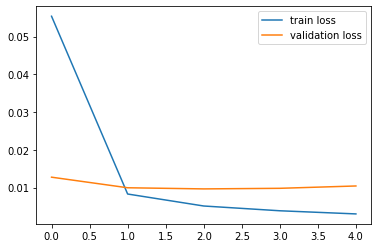

In [27]:
# loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()

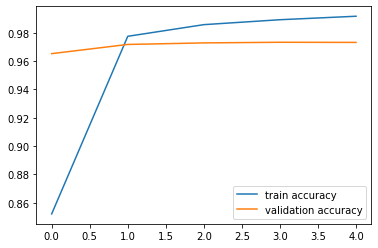

In [28]:
# accuracy per iteration
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()

In [29]:
train_lengths = [len(sentence) for sentence in train_inputs]
test_lengths = [len(sentence) for sentence in test_inputs]

In [30]:
# calculate accuracy and F1 score without padding
train_probs = model.predict(train_inputs_int)
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
    probs_ = probs[-length:]
    preds = np.argmax(probs_, axis=1)
    train_predictions.append(preds)

1255/1255 [==============================] - 24s 17ms/step


In [31]:
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

In [32]:
test_probs = model.predict(test_inputs_int)
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
    probs_ = probs[-length:]
    preds = np.argmax(probs_, axis=1)
    test_predictions.append(preds)

538/538 [==============================] - 10s 18ms/step


In [33]:
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

In [34]:
print('Train accuracy:', accuracy_score(flat_train_targets, flat_train_predictions))
print('Test accuracy:', accuracy_score(flat_test_targets, flat_test_predictions), '\n')

print('Train F1:', f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print('Test F1:', f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train accuracy: 0.993907481705856
Test accuracy: 0.9731323778737907 

Train F1: 0.9879299654683208
Test F1: 0.9251625320977309


In [35]:
# make predictions and calculate accuracy
def most_common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

In [36]:
token2tags = {k : [] for k, v in word2idx.items()}

In [37]:
del token2tags['UNK']

In [38]:
for tokens, tags in zip(train_inputs, train_targets):
    for token, tag in zip(tokens, tags):
        if should_lowercase:
            token = token.lower()
        if token in token2tags:
            token2tags[token].append(tag)
            
token2tag = {k: most_common(v) for k, v in token2tags.items()}

In [39]:
train_predictions = []
for sentence in train_inputs:
    predictions = []
    for token in sentence:
        if should_lowercase:
            token = token.lower()
        predicted_tag = token2tag[token]
        predictions.append(predicted_tag)
    train_predictions.append(predictions)
    
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [40]:
test_predictions = []
for sentence in test_inputs:
    predictions = []
    for token in sentence:
        predicted_tag = token2tag.get(token, 'INCORRECT')
        predictions.append(predicted_tag)
    test_predictions.append(predictions)
    
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)

In [41]:
print('Train accuracy:', accuracy_score(flat_train_targets, flat_train_predictions))
print('Test accuracy:', accuracy_score(flat_test_targets, flat_test_predictions), '\n')

print('Train F1:', f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print('Test F1:', f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train accuracy: 0.9574310167919045
Test accuracy: 0.9271373345960214 

Train F1: 0.9391517908146612
Test F1: 0.8223458102866388
